In [1]:
# Importing libraries for data handling, visualization, and deep learning
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import glob
from skimage.io import imread
import cv2
from PIL import Image
from skimage.transform import resize
import itertools
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from tensorflow.keras.models import save_model

In [2]:
# Constants
IMG_SIZE = 48
DATA_DIR = r"C:\Users\ASUS\.cache\kagglehub\datasets\tapakah68\facial-emotion-recognition\versions\2\images"
EMOTIONS = ['Anger', 'Contempt', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprised']

# Load the dataset
csv_path = r"C:\Users\ASUS\Downloads\emotions.csv"
emotions_df = pd.read_csv(csv_path)

In [3]:
# Function to load and preprocess images
import os
import cv2
import numpy as np

def load_data():
    images = []
    labels = []
    
    for emotion_label, emotion in enumerate(EMOTIONS):
        emotion_dir = os.path.join(DATA_DIR, str(emotion_label))
        if os.path.isdir(emotion_dir):
            for img_file in os.listdir(emotion_dir):
                img_path = os.path.join(emotion_dir, img_file)
                img_array = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                img_resized = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                images.append(img_resized)
                labels.append(emotion_label)
        else:
            print(f"Directory not found for emotion {emotion}: {emotion_dir}")
        
    return np.array(images), np.array(labels)

# Load the data
images, labels = load_data()


# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

# Normalize the pixel values
X_train = X_train / 255.0
X_test = X_test / 255.0

# Reshape data for CNN input
X_train = X_train.reshape(-1, IMG_SIZE, IMG_SIZE, 1)
X_test = X_test.reshape(-1, IMG_SIZE, IMG_SIZE, 1)

Number of images: 64
Shape of images array: (64, 48, 48)
Number of labels: 64


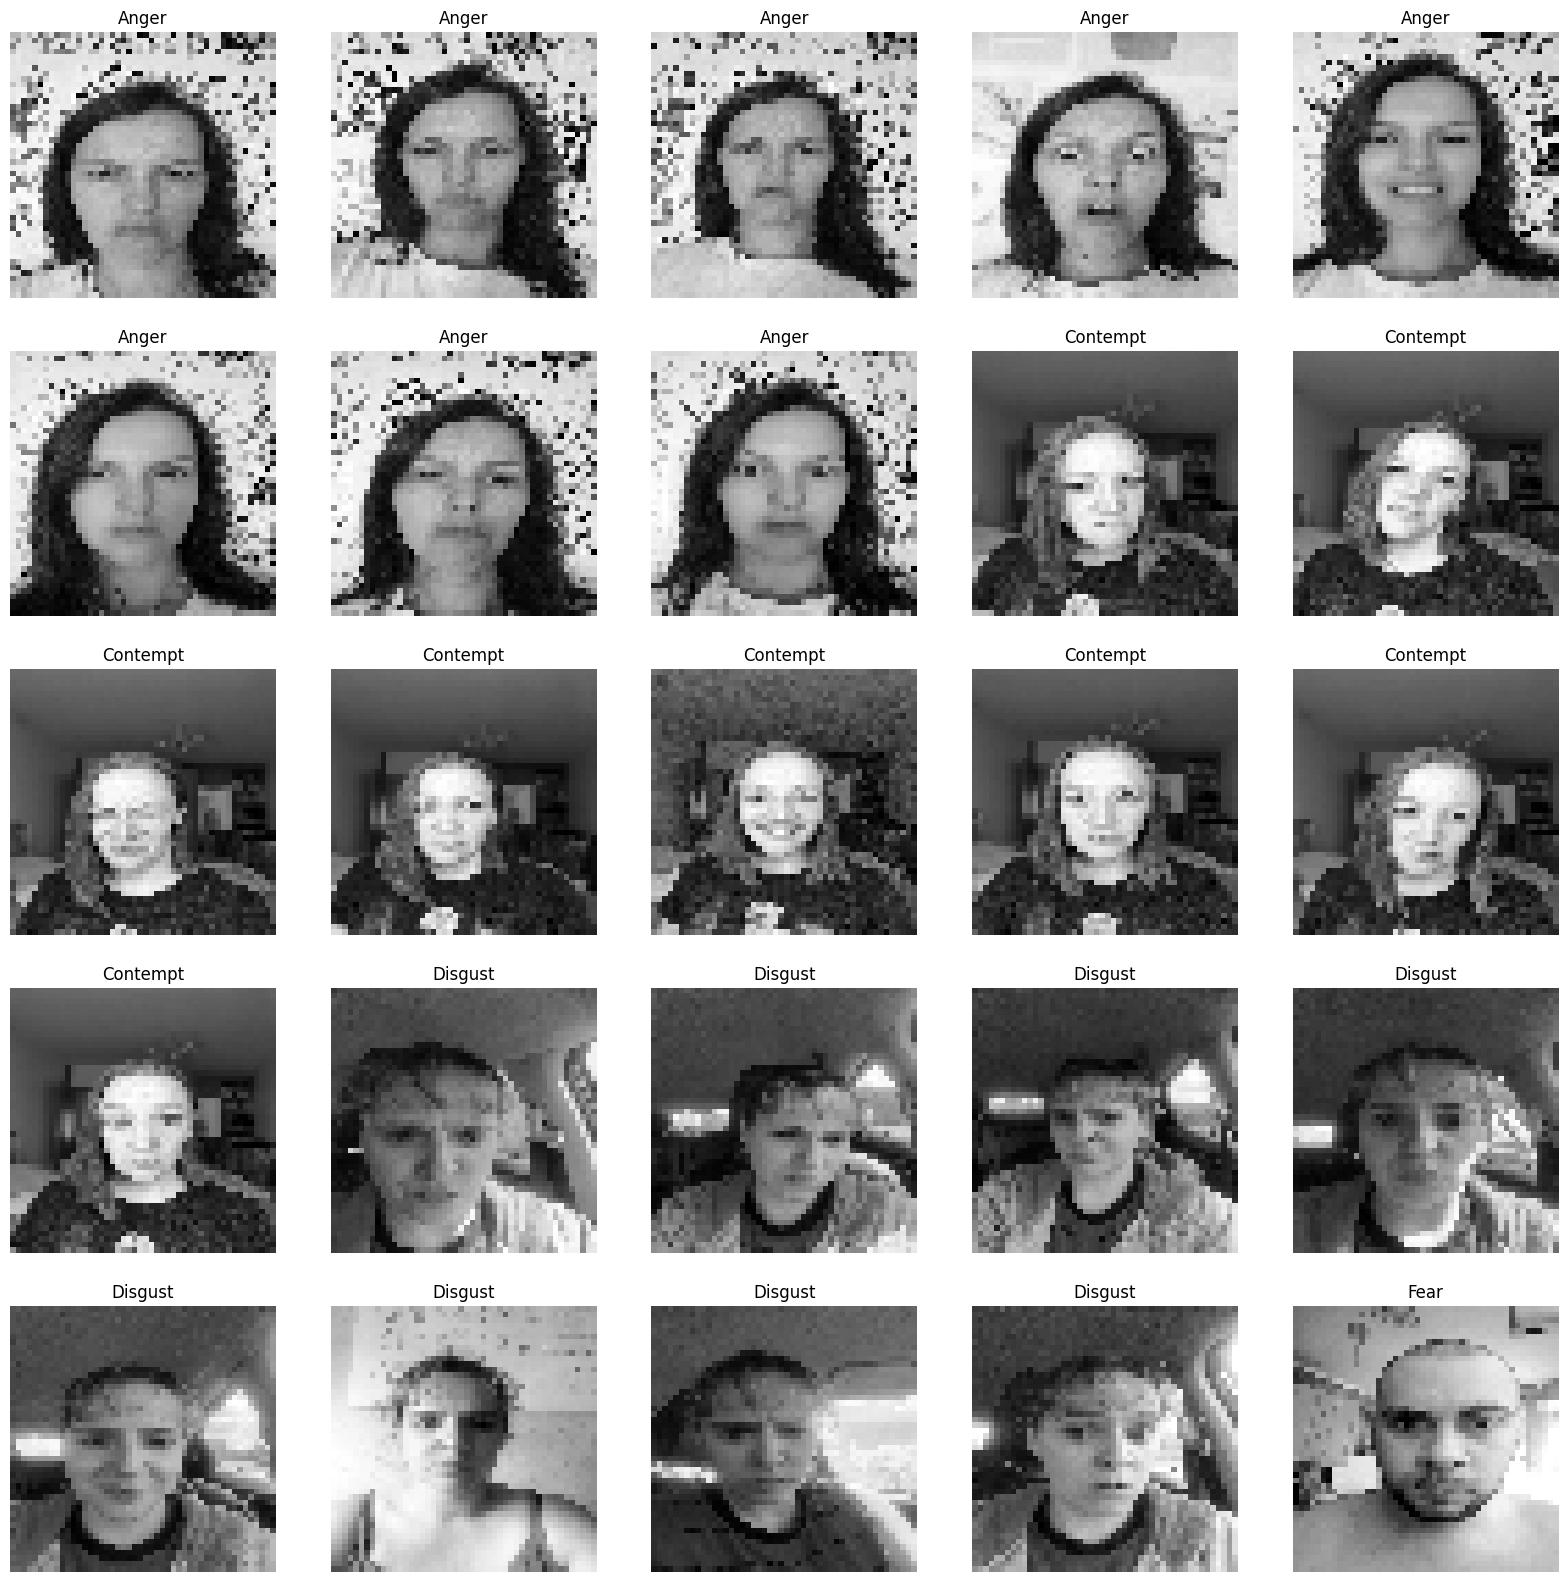

In [4]:
# Print information about the dataset
print("Number of images:", len(images))
print("Shape of images array:", images.shape)
print("Number of labels:", len(labels))

# Print sample images and their corresponding labels
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 20))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(images[i], cmap='gray')
    plt.title(EMOTIONS[labels[i]])
    plt.axis('off')
plt.show()

In [5]:
# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)
datagen.fit(X_train)

In [6]:
# Define the CNN model
model = models.Sequential([
    layers.Conv2D(64, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 1)),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),  # Dropout layer to prevent overfitting
    layers.Dense(len(EMOTIONS), activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

C:\Users\ASUS\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 46, 46, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 21, 21, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 485,384 (1.85 MB)

 Trainable params: 485,384 (1.85 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
# Train the model
history = model.fit(datagen.flow(X_train, y_train, batch_size=32), epochs=50, validation_data=(X_test, y_test))

Epoch 1/50


C:\Users\ASUS\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 194ms/step - accuracy: 0.1540 - loss: 2.0853 - val_accuracy: 0.2308 - val_loss: 2.0542
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.0627 - loss: 2.0825 - val_accuracy: 0.1538 - val_loss: 2.0324
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.1662 - loss: 2.0516 - val_accuracy: 0.0769 - val_loss: 2.0350
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.2446 - loss: 2.0121 - val_accuracy: 0.0769 - val_loss: 2.0600
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.1135 - loss: 2.0956 - val_accuracy: 0.1538 - val_loss: 2.0802
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.1572 - loss: 2.0471 - val_accuracy: 0.2308 - val_loss: 2.0847
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.2009 - loss: 1.9925 - val_accuracy: 0.1538 - val_loss: 2.0814
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.2768 - loss: 2.0110 - val_accuracy: 0.3077 - val_loss: 2.0653
Epoch 9/5

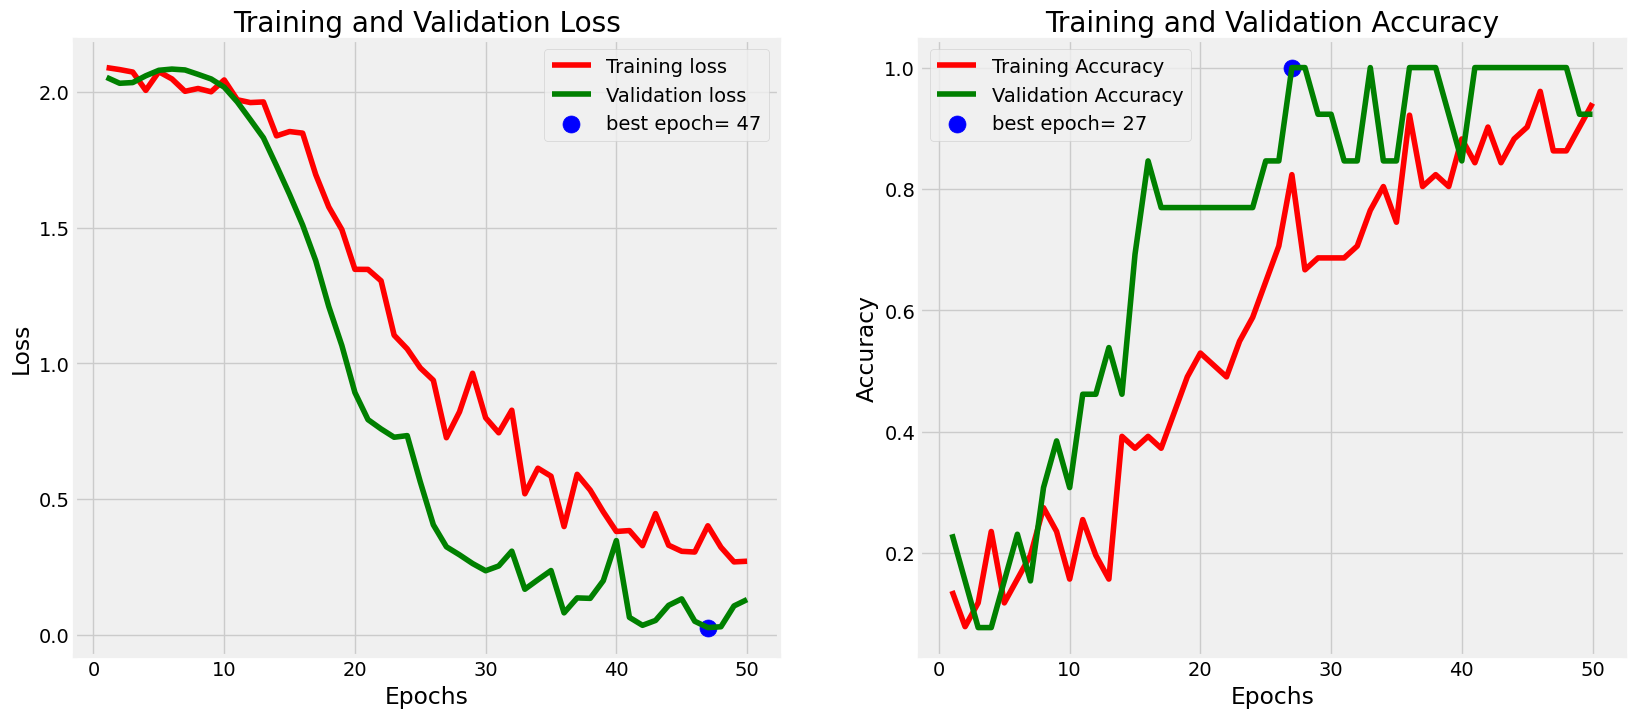

In [8]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [9]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=2)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

1/1 - 0s - 129ms/step - accuracy: 0.9231 - loss: 0.1303
Test Loss: 0.13026097416877747
Test Accuracy: 0.9230769276618958


In [10]:
from sklearn.metrics import classification_report

# Make predictions on the test set
predictions = model.predict(X_test)
predicted_labels = np.argmax(predictions, axis=1)

# Print classification report
print(classification_report(y_test, predicted_labels, target_names=EMOTIONS))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
              precision    recall  f1-score   support

       Anger       1.00      1.00      1.00         2
    Contempt       1.00      1.00      1.00         2
     Disgust       1.00      1.00      1.00         1
        Fear       1.00      1.00      1.00         1
       Happy       1.00      1.00      1.00         1
     Neutral       1.00      0.50      0.67         2
         Sad       0.50      1.00      0.67         1
   Surprised       1.00      1.00      1.00         3

    accuracy                           0.92        13
   macro avg       0.94      0.94      0.92        13
weighted avg       0.96      0.92      0.92        13



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


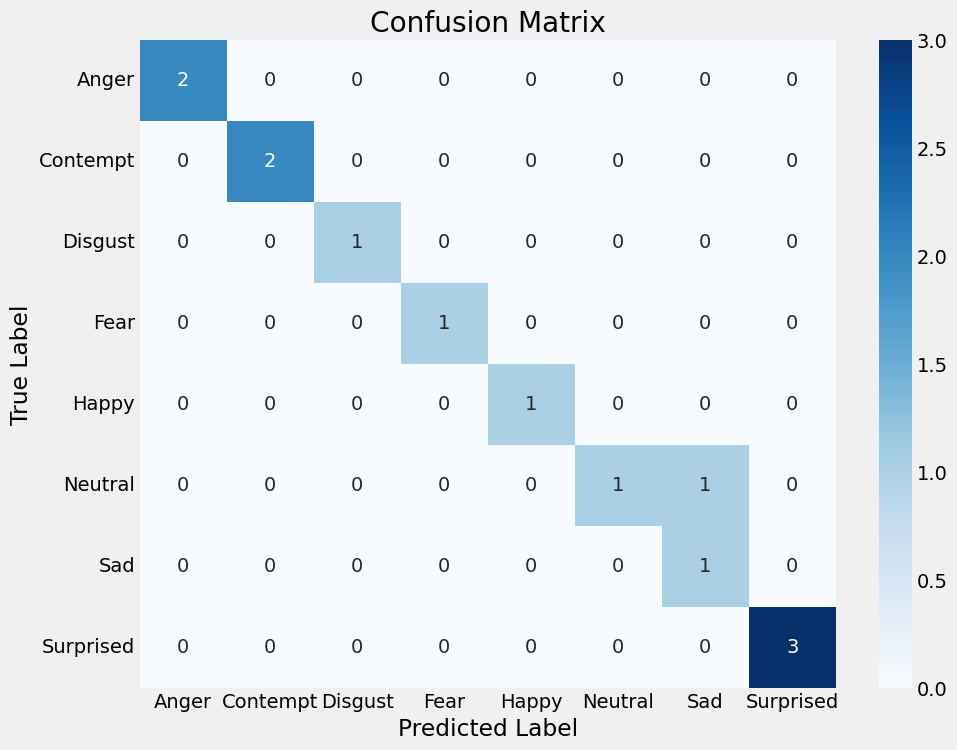

In [11]:
# Make predictions on the test set
predictions = model.predict(X_test)
predicted_labels = np.argmax(predictions, axis=1)

# Generate the confusion matrix
cm = confusion_matrix(y_test, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=EMOTIONS, yticklabels=EMOTIONS)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


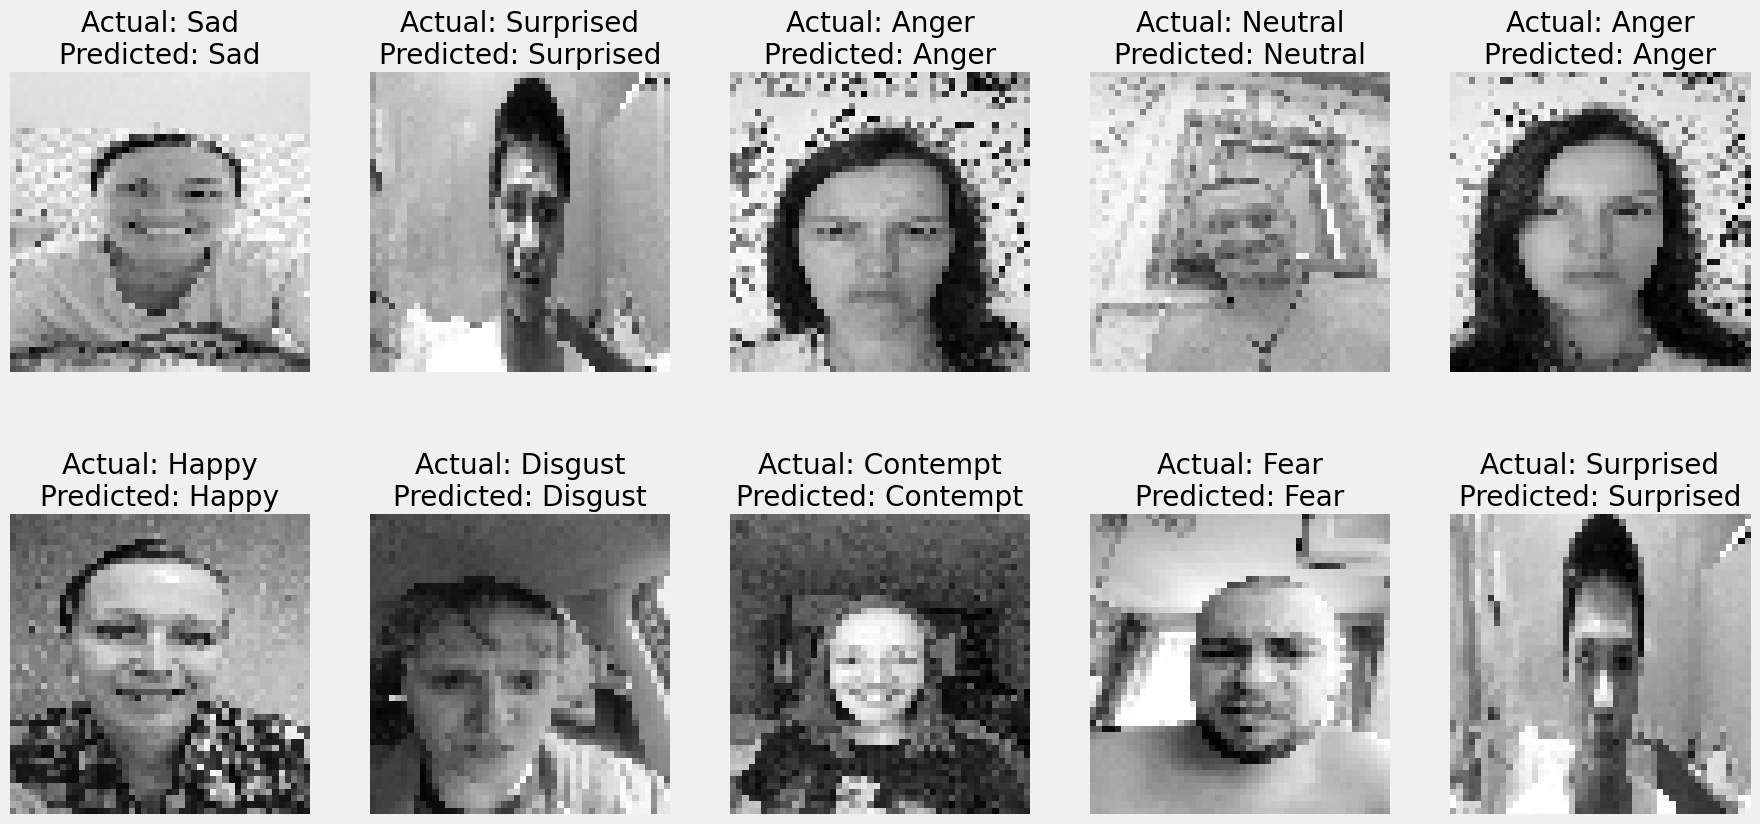

In [12]:
import matplotlib.pyplot as plt

# Make predictions on the test set
predictions = model.predict(X_test)
predicted_labels = np.argmax(predictions, axis=1)

# Function to display images with predicted and actual labels
def display_images(images, actual_labels, predicted_labels, emotions, num_images=10):
    plt.figure(figsize=(20, 10))
    for i in range(num_images):
        plt.subplot(2, 5, i + 1)
        # Since the images are grayscale, we reshape them to (48, 48)
        img = images[i].reshape(IMG_SIZE, IMG_SIZE)
        plt.imshow(img, cmap='gray')
        plt.title(f"Actual: {emotions[actual_labels[i]]}\nPredicted: {emotions[predicted_labels[i]]}")
        plt.axis('off')
    plt.show()

# Display the images with predicted and actual labels
display_images(X_test, y_test, predicted_labels, EMOTIONS)